In [46]:
# 90. word2vecによる学習
# 81で作成したコーパスを流用する
import re

with open("./enwiki-20150112-400-r10-105752.txt", "r") as rf, open("./enwiki-cleaned.txt", "w") as wf:
    for line in rf:
        tokens = [re.sub(r"^[\.,!?;:\(\)\[\]\'\"]+|[\.,!?;:\(\)\[\]\'\"]+$", "", token) for token in line.split() if re.sub(r"^[\.,!?;:\(\)\[\]\'\"]+|[\.,!?;:\(\)\[\]\'\"]+$", "", token) is not ""]
        wf.write(" ".join(tokens) + "\n")

with open("Countries.txt") as f:
    country_dict = {}
    for line in f:
        country_dict[line.replace("\n", "")] = line.replace(" ", "_").replace("\n", "")
        
# 以降の問いでも使うのでテキストを配列にする
sentences = []
with open("enwiki-cleaned.txt") as f:
    for line in f:
        rep_line = line
        for key in country_dict:
            rep_line = rep_line.replace(key, country_dict[key]).strip()
        if rep_line:
            sentences.append(rep_line.split())


In [48]:
# word2vecの利用はgensimで行う
from gensim.models.word2vec import Word2Vec 

%time model = Word2Vec(sentences, size=300, window=5, min_count=10)

CPU times: user 41min 42s, sys: 1min 46s, total: 43min 28s
Wall time: 18min 42s


In [49]:
# 単語ベクトルの表示
model["United_States"]

array([ -9.46990252e-01,  -2.20925391e-01,  -4.29126829e-01,
         1.76833427e+00,  -3.01550835e-01,  -2.71715783e-02,
        -4.16080981e-01,   6.43046737e-01,  -1.26192129e+00,
         4.25159037e-01,   1.12664855e+00,   5.53063393e-01,
        -4.01164562e-01,  -7.98924088e-01,  -9.22581673e-01,
         9.56283391e-01,   3.13540921e-02,   1.75685096e+00,
        -1.63640850e-03,  -1.02024460e+00,  -1.17204666e+00,
         9.09994170e-02,  -1.24407768e-01,   7.52447695e-02,
        -2.06808392e-02,   1.36249352e+00,   1.94466841e+00,
        -1.69327617e+00,   1.66654550e-02,   1.54904532e+00,
        -4.14547116e-01,   7.93690383e-02,  -5.85387826e-01,
         6.00258946e-01,  -1.76111996e-01,  -1.22749531e+00,
         7.24371433e-01,  -8.42755362e-02,   1.43912688e-01,
         2.21613836e+00,  -8.51255894e-01,   4.70758975e-01,
         9.74265039e-01,  -2.46687666e-01,  -1.62676287e+00,
         1.84217429e+00,  -2.76540041e-01,   1.94437337e+00,
         1.50088644e+00,

In [50]:
# 単語の類似度
model.n_similarity(["United_States"], ["U.S"])

0.85339820546351286

In [51]:
# 類似度の高い単語10件
model.most_similar(positive=["England"])

[('Scotland', 0.7149522304534912),
 ('Britain', 0.6780800819396973),
 ('Great_Britain', 0.6233570575714111),
 ('France', 0.596176266670227),
 ('Ireland', 0.5948725938796997),
 ('Wales', 0.5944497585296631),
 ('Hampshire', 0.5925918817520142),
 ('Cornwall', 0.5789928436279297),
 ('Worcestershire', 0.5626083016395569),
 ('Essex', 0.5539456605911255)]

In [52]:
# 加法構成性によるアナロジー
model.most_similar(positive=["Spain", "Athens"], negative=["Madrid"])

[('Greece', 0.7028288841247559),
 ('Crete', 0.5972165465354919),
 ('Persia', 0.5758514404296875),
 ('Epirus', 0.5681356191635132),
 ('Gaul', 0.5615759491920471),
 ('Byzantium', 0.5591870546340942),
 ('Armenia', 0.5539459586143494),
 ('Cyprus', 0.5457242727279663),
 ('Britain', 0.5450823307037354),
 ('Iberia', 0.5374140739440918)]

In [56]:
# 91. アナロジーデータの準備
with open("questions-words.txt") as f:
    validate_data = [sec for sec in f.read().split(":") if "family" in sec.split("\n")[0]][0].split("\n")[1:-1]

In [57]:
# 92. アナロジーデータへの適用
# 90.で作成した単語ベクトルに適用
for i, sample in enumerate(validate_data):
    words = sample.split()
    # if all([word in model for word in words]):
    most_similar = model.most_similar(positive=[words[1], words[2]], negative=[words[0]])[0]
    if i <= 10:
        print("test: {}\tmodel_predict: {}".format(words[3], most_similar[0]))
    words.extend([most_similar[0], str(most_similar[1])])
    validate_data[i] = " ".join(words)

test: sister	model_predict: sister
test: sisters	model_predict: sisters
test: mom	model_predict: mom
test: mother	model_predict: mother
test: grandmother	model_predict: grandmother
test: grandma	model_predict: Infectia
test: granddaughter	model_predict: granddaughter
test: bride	model_predict: bride
test: she	model_predict: she
test: her	model_predict: her
test: wife	model_predict: fiancé


In [58]:
# 93. アナロジータスクの正解率の計算
len([sample for sample in validate_data if sample.split()[3] == sample.split()[4]]) / len(validate_data)

0.66600790513834

In [61]:
# 94. WordSimilarity-353での類似度計算
import csv
with open("combined.csv") as f:
    ws_353 = [row for row in csv.DictReader(f)]

In [65]:
for i, sample in enumerate(ws_353):
    sample["model_score"] = model.n_similarity(sample["Word 1"], sample["Word 2"])
    ws_353[i] = sample

In [75]:
# 95. WordSimilarity-353での評価
for i, sample in enumerate(sorted(ws_353, key=lambda x:x["Human (mean)"], reverse=True)):
    sample["Human_rank"] = i
    ws_353[i] = sample
    
for i, sample in enumerate(sorted(ws_353, key=lambda x:x["model_score"], reverse=True)):
    sample["model_rank"] = i
    ws_353[i] = sample

In [79]:
# スピアマン相関係数が0に近いということは人間の類似度判定とモデルの類似度判定には相関がほぼない
# WS-353でつけた人間の考える類似度とword2vecの学習する類似度が違うものである可能性がある
import math
n = len(ws_353)
speaman_rank_correlation = 1 - ((6 * sum([math.pow(sample["Human_rank"] - sample["model_rank"], 2) for sample in ws_353])) / (math.pow(n, 3) - n))
print(speaman_rank_correlation)

-0.08027849557174482


In [98]:
# 96. 国名に関するベクトルの抽出
countries = country_dict.values()
country_vectors = [(country, model[country]) for country in countries if country in model]

In [99]:
# 97. k-meansクラスタリング
from sklearn.cluster import KMeans
import numpy

X = numpy.array([country[1] for country in country_vectors])
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

In [100]:
kmeans.labels_

array([1, 1, 1, 2, 0, 3, 4, 0, 1, 1, 1, 1, 1, 0, 2, 1, 3, 2, 0, 1, 1, 1, 4,
       0, 0, 0, 1, 1, 1, 2, 1, 3, 1, 4, 3, 1, 1, 1, 1, 0, 1, 4, 4, 1, 3, 3,
       1, 0, 3, 1, 0, 2, 4, 1, 3, 2, 3, 1, 1, 3, 1, 1, 3, 0, 1, 3, 1, 3, 1,
       1, 1, 0, 4, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 0, 3, 1,
       2, 0, 4, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 3, 1, 3, 1, 1, 0,
       0, 1, 1, 3, 1, 1, 3, 1, 3, 2, 2, 1, 1, 1, 2, 3, 1, 0, 1, 1, 1, 1, 3,
       1, 4, 1, 1, 1, 1, 4, 1, 0, 0, 1, 0, 3, 3, 3, 1, 3, 2, 1, 2, 1, 1, 2,
       2, 0, 2, 4, 1, 1, 1, 2, 2, 4, 4, 1, 1, 2, 3, 1, 3, 3, 4, 0, 0, 1, 0,
       1, 0, 2, 1, 2, 3, 3, 3, 1, 1, 1, 1, 0, 3, 3, 1, 0, 2, 4, 4, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 3, 0, 0, 2, 3, 2, 1, 4, 2, 1, 1, 1, 0, 1], dtype=int32)

In [135]:
clusters = {}
clusters[0], clusters[1], clusters[2], clusters[3], clusters[4] = [], [], [], [], []
for cluster_idx, country in zip(kmeans.labels_, country_vectors):
    clusters[cluster_idx].append(country)

# 各クラスターの国を３件だけ表示
for cluster_idx, cluster in clusters.items():
    print("cluster {}".format(str(cluster_idx)))
    for country in cluster[:3]:
        print(country[0])
    print("\n")

cluster 0
Belgium
Albania
Lithuania


cluster 1
Chad
Greenland
Rwanda


cluster 2
Canada
Brazil
United_States


cluster 3
Mongolia
Iraq
Laos


cluster 4
China
Japan
Malaysia




In [101]:
# 98. Ward法によるクラスタリング
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline

Z = linkage(X, "ward")

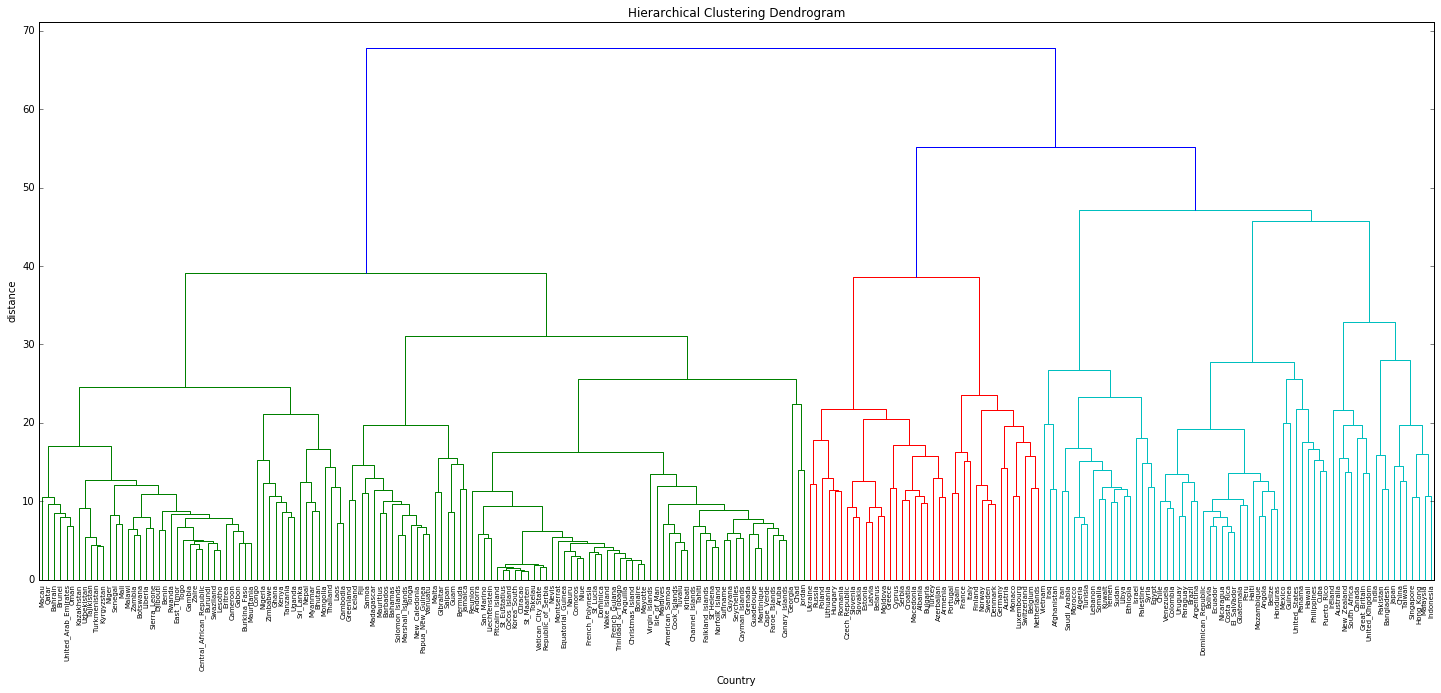

In [109]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Country')
plt.ylabel('distance')
dendrogram(Z, leaf_font_size=7., labels=numpy.array([country[0] for country in country_vectors]))
plt.show()

In [136]:
# 99. t-SNEによる可視化
from sklearn.manifold import TSNE

model = TSNE(n_components=2, learning_rate=1000, perplexity=30)
compact_X = model.fit_transform(X)

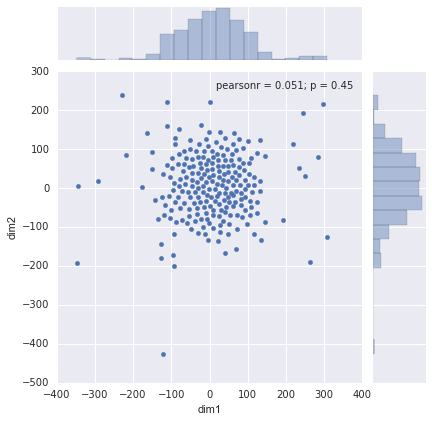

In [137]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(compact_X, columns=["dim1", "dim2"])
sns.jointplot("dim1", "dim2", data=df)